<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#load-data" data-toc-modified-id="load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>load data</a></span><ul class="toc-item"><li><span><a href="#read-in-the-files" data-toc-modified-id="read-in-the-files-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>read in the files</a></span><ul class="toc-item"><li><span><a href="#data-from-linear-and-relu-activations" data-toc-modified-id="data-from-linear-and-relu-activations-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>data from linear and relu activations</a></span></li></ul></li><li><span><a href="#create-pandas-table" data-toc-modified-id="create-pandas-table-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>create pandas table</a></span></li></ul></li><li><span><a href="#filter-out-bad-training-losses" data-toc-modified-id="filter-out-bad-training-losses-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>filter out bad training losses</a></span></li><li><span><a href="#determine-the-lambda-parameter-that-gets-the-best-validation-MSE-for-each-(r,n,L)" data-toc-modified-id="determine-the-lambda-parameter-that-gets-the-best-test-MSE-for-each-(r,n,L)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>determine the lambda parameter that gets the best test MSE for each (r,n,L)</a></span></li><li><span><a href="#Generalization-MSE" data-toc-modified-id="Generalization-MSE-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Generalization MSE</a></span><ul class="toc-item"><li><span><a href="#generate-data" data-toc-modified-id="generate-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>generate data</a></span></li><li><span><a href="#compute-MSE" data-toc-modified-id="compute-MSE-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>compute MSE</a></span></li></ul></li><li><span><a href="#Out-of-Distribution-MSE" data-toc-modified-id="Out-of-Distribution-MSE-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Out of Distribution MSE</a></span><ul class="toc-item"><li><span><a href="#generate-data" data-toc-modified-id="generate-data-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>generate data</a></span></li><li><span><a href="#compute-MSE" data-toc-modified-id="compute-MSE-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>compute MSE</a></span></li></ul></li><li><span><a href="#Active-Subspace" data-toc-modified-id="Active-Subspace-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Active Subspace</a></span><ul class="toc-item"><li><span><a href="#evaluate-gradients-and-compute-singular-values-and-active-subspaces" data-toc-modified-id="evaluate-gradients-and-compute-singular-values-and-active-subspaces-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>evaluate gradients and compute singular values and active subspaces</a></span></li><li><span><a href="#plot-of-singular-values" data-toc-modified-id="plot-of-singular-values-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>plot of singular values</a></span></li></ul></li><li><span><a href="#determine-the-L-parameter-that-gets-the-best-test-MSE-for-each-(r,n)" data-toc-modified-id="determine-the-L-parameter-that-gets-the-best-test-MSE-for-each-(r,n)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>determine the L parameter that gets the best test MSE for each (r,n)</a></span></li><li><span><a href="#Plots-of-L-vs-Test-error-and-n-vs-Generalization-metrics-with/without-linear-layers" data-toc-modified-id="Plots-of-L-vs-Validation-error-and-n-vs-Generalization-metrics-with/without-linear-layers-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plots of L vs Test error and n vs Generalization metrics with/without linear layers</a></span></li><li><span><a href="#Final-Table" data-toc-modified-id="Final-Table-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Final Table</a></span></li><li><span><a href="#Training-Time-Plots" data-toc-modified-id="Training-Time-Plots-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Training Time Plots</a></span><ul class="toc-item"><li><span><a href="#Train-MSE-v-Epoch" data-toc-modified-id="Train-MSE-v-Epoch-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Train MSE v Epoch</a></span></li><li><span><a href="#Weight-Decay-v-Epoch" data-toc-modified-id="Weight-Decay-v-Epoch-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Weight Decay v Epoch</a></span></li><li><span><a href="#learning-rates" data-toc-modified-id="learning-rates-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>learning rates</a></span></li></ul></li></ul></div>

# imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import ortho_group
from scipy.stats import linregress
from scipy import linalg as la
from torch import nn
import torch
import os
from matplotlib.lines import Line2D
from scipy.stats import sem
from mpl_toolkits import mplot3d

# load data

## read in the files

In [ ]:
rnvals = [(1,64),(1,128),(1,256),(1,512)]#,(1,1024),(1,2048),
          #(2,64),(2,128),(2,256),(2,512),(2,1024),(2,2048),
          #(5,64),(5,128),(5,256),(5,512),(5,1024),(5,2048),]
Ls = [2,3,4,5,6,7,8,9]
rs = [1]#,2,5]
wds = [1e-3,1e-4,1e-5]
labelnoise = [0,0.25]#,0.5,1]
epochs = 60100
job_name = "middlelinear_SIM"
path = "" #path to results

In [ ]:
testMSEs = {}
trainMSEs = {}
weightdecays = {}
learningrates = {}
files_found_list = []
for r,n in rnvals:
    for L in Ls:
        for wd in wds:
            for ln in labelnoise:
                paramname = job_name + f"_labelnoise{ln}"+f"/N{n}_L{L}_r{r}_wd{wd}_epochs{epochs}"
                if os.path.exists(path+paramname+"testMSE.npy"):
                    testMSEs[r,n,L,wd,ln] = np.load(path+paramname+"testMSE.npy",allow_pickle=True).item()
                    trainMSEs[r,n,L,wd,ln] = np.load(path+paramname+"trainMSEs.npy",allow_pickle=True)
                    weightdecays[r,n,L,wd,ln] = np.load(path+paramname+"weightdecays.npy",allow_pickle=True)
                    learningrates[r,n,L,wd,ln] = np.load(path+paramname+"learningrates.npy",allow_pickle=True)
                    files_found_list.append((r,n,L,wd,ln))
                else:
                    print(f"{paramname+'testMSE.npy'} not found")

In [4]:
files_found_list

[(1, 64, 2, 0.001, 0),
 (1, 64, 2, 0.001, 0.25),
 (1, 64, 2, 0.0001, 0),
 (1, 64, 2, 0.0001, 0.25),
 (1, 64, 2, 1e-05, 0),
 (1, 64, 2, 1e-05, 0.25),
 (1, 64, 3, 0.001, 0),
 (1, 64, 3, 0.001, 0.25),
 (1, 64, 3, 0.0001, 0),
 (1, 64, 3, 0.0001, 0.25),
 (1, 64, 3, 1e-05, 0),
 (1, 64, 3, 1e-05, 0.25),
 (1, 64, 4, 0.001, 0),
 (1, 64, 4, 0.001, 0.25),
 (1, 64, 4, 0.0001, 0),
 (1, 64, 4, 0.0001, 0.25),
 (1, 64, 4, 1e-05, 0),
 (1, 64, 4, 1e-05, 0.25),
 (1, 64, 5, 0.001, 0),
 (1, 64, 5, 0.001, 0.25),
 (1, 64, 5, 0.0001, 0),
 (1, 64, 5, 0.0001, 0.25),
 (1, 64, 5, 1e-05, 0),
 (1, 64, 5, 1e-05, 0.25),
 (1, 64, 6, 0.001, 0),
 (1, 64, 6, 0.001, 0.25),
 (1, 64, 6, 0.0001, 0),
 (1, 64, 6, 0.0001, 0.25),
 (1, 64, 6, 1e-05, 0),
 (1, 64, 6, 1e-05, 0.25),
 (1, 64, 7, 0.001, 0),
 (1, 64, 7, 0.001, 0.25),
 (1, 64, 7, 0.0001, 0),
 (1, 64, 7, 0.0001, 0.25),
 (1, 64, 7, 1e-05, 0),
 (1, 64, 7, 1e-05, 0.25),
 (1, 64, 8, 0.001, 0),
 (1, 64, 8, 0.001, 0.25),
 (1, 64, 8, 0.0001, 0),
 (1, 64, 8, 0.0001, 0.25),
 (1, 6

In [5]:
def Llayers(L,d=20,width=1000,relus=False,middlelinear=True):
    """
    model class. Construct L-1 linear layers; bias terms only on last linear layer and final relu layer.
    """
    if L < 2:
        raise ValueError("L must be at least 2")
    if L == 2:
        linear_layers = [nn.Linear(d,width,bias=True)]
    if L > 2:
        linear_layers = [nn.Linear(d,width,bias=False)]
        if relus or middlelinear: linear_layers.append(nn.ReLU())
        for l in range(L-3):
            linear_layers.append(nn.Linear(width,width,bias=False))
            if relus: linear_layers.append(nn.ReLU())
        linear_layers.append(nn.Linear(width,width,bias=True))

    relu = nn.ReLU()

    last_layer = nn.Linear(width,1)

    layers = linear_layers + [relu,last_layer]

    return nn.Sequential(*layers)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
files_found_list = []
models = {}
for r,n in rnvals:
    for L in Ls:
        for wd in wds:
            for ln in labelnoise:
                paramname = job_name + f"_labelnoise{ln}/N{n}_L{L}_r{r}_wd{wd}_epochs{epochs}"
                if os.path.exists(path+paramname+"model.pt"):
                    models[r,n,L,wd,ln] = Llayers(L,width=1000)
                    models[r,n,L,wd,ln].to(device)
                    if torch.cuda.is_available():
                        models[r,n,L,wd,ln].load_state_dict(torch.load(path+paramname+"model.pt"))
                    else:
                        models[r,n,L,wd,ln].load_state_dict(torch.load(path+paramname+"model.pt"),map_location=torch.device('cpu'))
                    models[r,n,L,wd,ln].eval()
                    files_found_list.append((r,n,L,wd,ln))
                else:
                    print(paramname+"model.pt","not found")

In [8]:
files_found_list

[(1, 64, 2, 0.001, 0),
 (1, 64, 2, 0.001, 0.25),
 (1, 64, 2, 0.0001, 0),
 (1, 64, 2, 0.0001, 0.25),
 (1, 64, 2, 1e-05, 0),
 (1, 64, 2, 1e-05, 0.25),
 (1, 64, 3, 0.001, 0),
 (1, 64, 3, 0.001, 0.25),
 (1, 64, 3, 0.0001, 0),
 (1, 64, 3, 0.0001, 0.25),
 (1, 64, 3, 1e-05, 0),
 (1, 64, 3, 1e-05, 0.25),
 (1, 64, 4, 0.001, 0),
 (1, 64, 4, 0.001, 0.25),
 (1, 64, 4, 0.0001, 0),
 (1, 64, 4, 0.0001, 0.25),
 (1, 64, 4, 1e-05, 0),
 (1, 64, 4, 1e-05, 0.25),
 (1, 64, 5, 0.001, 0),
 (1, 64, 5, 0.001, 0.25),
 (1, 64, 5, 0.0001, 0),
 (1, 64, 5, 0.0001, 0.25),
 (1, 64, 5, 1e-05, 0),
 (1, 64, 5, 1e-05, 0.25),
 (1, 64, 6, 0.001, 0),
 (1, 64, 6, 0.001, 0.25),
 (1, 64, 6, 0.0001, 0),
 (1, 64, 6, 0.0001, 0.25),
 (1, 64, 6, 1e-05, 0),
 (1, 64, 6, 1e-05, 0.25),
 (1, 64, 7, 0.001, 0),
 (1, 64, 7, 0.001, 0.25),
 (1, 64, 7, 0.0001, 0),
 (1, 64, 7, 0.0001, 0.25),
 (1, 64, 7, 1e-05, 0),
 (1, 64, 7, 1e-05, 0.25),
 (1, 64, 8, 0.001, 0),
 (1, 64, 8, 0.001, 0.25),
 (1, 64, 8, 0.0001, 0),
 (1, 64, 8, 0.0001, 0.25),
 (1, 6

## create pandas table

In [9]:
res = {
  "r"                                    : [r                          for r,n,L,wd,ln in files_found_list],# + [r                         for wd in wds for r,n in relu_rnvals],
  "sigma"                                : [ln                         for r,n,L,wd,ln in files_found_list],# + [ln                        for wd in wds for r,n in relu_rnvals],
  "n"                                    : [n                          for r,n,L,wd,ln in files_found_list],# + [n                         for wd in wds for r,n in relu_rnvals],
  "L"                                    : [L                          for r,n,L,wd,ln in files_found_list],# + [4                         for wd in wds for r,n in relu_rnvals],
  "lambda"                               : [wd                         for r,n,L,wd,ln in files_found_list],# + [wd                        for wd in wds for r,n in relu_rnvals],
  "Learning Rate"                        : [learningrates[r,n,L,wd,ln] for r,n,L,wd,ln in files_found_list],# + [RELUlearningrates[r,n][4][wd] for wd in wds for r,n in relu_rnvals],
  "Train MSE"                            : [trainMSEs[r,n,L,wd,ln]     for r,n,L,wd,ln in files_found_list],# + [RELUtrainMSEs[r,n][4][wd]     for wd in wds for r,n in relu_rnvals],
  "Weight Decay"                         : [weightdecays[r,n,L,wd,ln]  for r,n,L,wd,ln in files_found_list],# + [RELUweightdecays[r,n][4][wd]  for wd in wds for r,n in relu_rnvals],
  "Model"                                : [models[r,n,L,wd,ln]        for r,n,L,wd,ln in files_found_list],# + [RELUmodels[r,n,4,wd]          for wd in wds for r,n in relu_rnvals],
  "Test MSE"                             : [testMSEs[r,n,L,wd,ln]      for r,n,L,wd,ln in files_found_list],# + [RELUtestMSEs[r,n][4][wd].item()      for wd in wds for r,n in relu_rnvals],
  "Activations"                          : ["relu"          for r,n,L,wd,ln in files_found_list],# + ["relu only"         for wd in wds for r,n in relu_rnvals]
}
res = pd.DataFrame(res)
res["Final Train MSE"] = [r[-1] for r in res["Train MSE"]]
res["Final Weight Decay"] = [r[-1] for r in res["Weight Decay"]]
res

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015077,relu,1.325944e-05,224.601898
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.188534,relu,6.019206e-06,232.990173
2,1,0.00,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8729, 1340.8097, 1340.7502, 1340.6937, 1...","[Linear(in_features=20, out_features=1000, bia...",0.028895,relu,5.553246e-08,226.878784
3,1,0.25,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19432, 60.090363, 59.986618, 59.883083, 59...","[1340.8741, 1340.8131, 1340.7559, 1340.7021, 1...","[Linear(in_features=20, out_features=1000, bia...",0.261582,relu,8.704664e-09,235.092911
4,1,0.00,64,2,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8796, 1340.8251, 1340.7732, 1340.7236, 1...","[Linear(in_features=20, out_features=1000, bia...",0.474495,relu,1.170539e-12,251.905258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,0.25,512,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.214455, 29.384083, 23.153172, 9.058229, 3....","[29117.865, 29085.053, 29010.55, 28983.273, 29...","[Linear(in_features=20, out_features=1000, bia...",0.152909,relu,5.194551e-06,264.140991
188,1,0.00,512,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[41.916046, 29.09217, 22.929085, 9.113097, 3.2...","[29282.191, 29282.56, 29232.979, 29230.559, 29...","[Linear(in_features=20, out_features=1000, bia...",0.020823,relu,5.616591e-08,285.982910
189,1,0.25,512,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.150757, 29.35722, 23.19595, 9.174357, 3.32...","[29282.027, 29282.285, 29232.494, 29230.695, 2...","[Linear(in_features=20, out_features=1000, bia...",0.178614,relu,4.514669e-07,309.675995
190,1,0.00,512,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[41.909107, 29.084482, 22.916782, 9.090255, 3....","[29308.234, 29316.592, 29273.602, 29277.896, 2...","[Linear(in_features=20, out_features=1000, bia...",0.077581,relu,6.476893e-07,965.641357


# filter out bad training losses

In [10]:
trainMSE_threshold = 1e-2

In [11]:
res[res["Final Train MSE"] >= trainMSE_threshold + res["sigma"]] #TODO is this reasonable?

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay


In [12]:
res = res[res["Final Train MSE"] < trainMSE_threshold + res["sigma"]]
res

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015077,relu,1.325944e-05,224.601898
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.188534,relu,6.019206e-06,232.990173
2,1,0.00,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8729, 1340.8097, 1340.7502, 1340.6937, 1...","[Linear(in_features=20, out_features=1000, bia...",0.028895,relu,5.553246e-08,226.878784
3,1,0.25,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19432, 60.090363, 59.986618, 59.883083, 59...","[1340.8741, 1340.8131, 1340.7559, 1340.7021, 1...","[Linear(in_features=20, out_features=1000, bia...",0.261582,relu,8.704664e-09,235.092911
4,1,0.00,64,2,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8796, 1340.8251, 1340.7732, 1340.7236, 1...","[Linear(in_features=20, out_features=1000, bia...",0.474495,relu,1.170539e-12,251.905258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,0.25,512,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.214455, 29.384083, 23.153172, 9.058229, 3....","[29117.865, 29085.053, 29010.55, 28983.273, 29...","[Linear(in_features=20, out_features=1000, bia...",0.152909,relu,5.194551e-06,264.140991
188,1,0.00,512,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[41.916046, 29.09217, 22.929085, 9.113097, 3.2...","[29282.191, 29282.56, 29232.979, 29230.559, 29...","[Linear(in_features=20, out_features=1000, bia...",0.020823,relu,5.616591e-08,285.982910
189,1,0.25,512,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.150757, 29.35722, 23.19595, 9.174357, 3.32...","[29282.027, 29282.285, 29232.494, 29230.695, 2...","[Linear(in_features=20, out_features=1000, bia...",0.178614,relu,4.514669e-07,309.675995
190,1,0.00,512,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[41.909107, 29.084482, 22.916782, 9.090255, 3....","[29308.234, 29316.592, 29273.602, 29277.896, 2...","[Linear(in_features=20, out_features=1000, bia...",0.077581,relu,6.476893e-07,965.641357


# generate data function


In [ ]:
def gen_data(datasetsize,r,seed,std,labelnoiseseed,trainsize=2**18,testsize=2**10,d=20,funcseed=42,verbose=False,ood=False):

    ##Generate data with a true central subspaces of varying dimensions
    #generate X values for training and test sets
    np.random.seed(seed) #set seed for data generation
    trainX = np.random.rand(d,trainsize).astype(np.float32)[:,:datasetsize] - 0.5 #distributed as U[-1/2, 1/2]
    testX = np.random.rand(d,testsize).astype(np.float32) - 0.5 #distributed as U[-1/2, 1/2]
    #out of distribution datagen
    if ood:
        trainX *= 2 #now distributed as U[-1, 1]
        testX *= 2 #now distributed as U[-1, 1]
    ##for each $r$ value create and store data-gen functions and $y$ evaluations
    #geneate params for functions
    k = d+1
    U = np.load(path+job_name+f"_labelnoise{std}/r{r}U.npy")
    Sigma = np.load(path+job_name+f"_labelnoise{std}/r{r}Sigma.npy")
    V = np.load(path+job_name+f"_labelnoise{std}/r{r}V.npy")
    A = np.load(path+job_name+f"_labelnoise{std}/r{r}A.npy")
    B = np.load(path+job_name+f"_labelnoise{std}/r{r}B.npy")
    #create functions
    np.random.seed(labelnoiseseed) #set seed for data generation
    def g(z): #active subspace function
        hidden_layer = (U*Sigma)@z
        hidden_layer = hidden_layer.T + B
        hidden_layer = np.maximum(0,hidden_layer).T
        return A@hidden_layer
    def f(x): #teacher network
        z = V.T@x    
        eps = std*np.random.randn(x.shape[1])    
        return g(z) + eps
    #generate data
    trainY = f(trainX).astype(np.float32)
    testY = f(testX).astype(np.float32)
    #move data to device
    if verbose:
        print("device: {}".format(device))
    trainX = torch.from_numpy(trainX).T.to(device)
    trainY = torch.from_numpy(trainY).to(device)
    testX = torch.from_numpy(testX).T.to(device)
    testY = torch.from_numpy(testY).to(device)
    if verbose:
        print("trainX shape = {} trainY shape = {}".format(
            trainX.shape,
            trainY.shape
        ))
    return trainX,trainY,testX,testY


# Validation MSE


## generate data


In [14]:
validationY = {}

validationsize = 2048
for r in rs:
    for k,std in enumerate(labelnoise):
        labelnoiseseed = 686 + k
        datagenseed = 1107
        print("validation size =",validationsize,"r =",r,"label noise std =",std,"label noise seed =",labelnoiseseed)
        validationX,validationY[r,std] = gen_data(datasetsize=validationsize,r=r,seed=datagenseed,std=std,labelnoiseseed=labelnoiseseed)[:2]
validationX.min(),validationX.max()


validation size = 2048 r = 1 label noise std = 0 label noise seed = 686
validation size = 2048 r = 1 label noise std = 0.25 label noise seed = 687


(tensor(-0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))

## compute squared errors


In [15]:
with torch.no_grad():
    validation = []
    normalized_validation = []
    squared_errors = []
    validation_sem = []
    validation_std = []
    for rownum, row in res.iterrows():
        print(row)
        std = row["sigma"]
        predY = row["Model"](validationX)
        squared_err = (predY[:,0] - validationY[row["r"],std])**2
        squared_err = squared_err.cpu().numpy()
        mse = nn.functional.mse_loss(predY[:,0],validationY[row["r"],std]).item()
        assert np.isclose(mse,np.mean(squared_err))
        validation.append(mse)
        sem_sqared_err = sem(squared_err)
        validation_sem.append(sem_sqared_err)
        std_sqared_err = np.std(squared_err)
        validation_std.append(std_sqared_err)
        if std > 0:
            normalized_validation.append(mse/(std**2))
        else:
            normalized_validation.append(np.nan)
        squared_errors.append(squared_err)
    res["Validation MSE"] = validation
    res["Validation MSE$/\sigma^2$"] = normalized_validation
    res["Validation Squared Errors"] = squared_errors
    res["Validation SEM"] = validation_sem
    res["Validation STD of Squared Errors"] = validation_std
res

r                                                                     1
sigma                                                               0.0
n                                                                    64
L                                                                     2
lambda                                                            0.001
Learning Rate         [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...
Train MSE             [60.264137, 60.159626, 60.055336, 59.95126, 59...
Weight Decay          [1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...
Model                 [Linear(in_features=20, out_features=1000, bia...
Test MSE                                                       0.015077
Activations                                                        relu
Final Train MSE                                                0.000013
Final Weight Decay                                           224.601898
Name: 0, dtype: object
r                                        

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay,Validation MSE,Validation MSE$/\sigma^2$,Validation Squared Errors,Validation SEM,Validation STD of Squared Errors
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015077,relu,1.325944e-05,224.601898,0.016125,NaN,"[0.00016370519, 0.00055622234, 0.011556946, 0....",0.001887,0.085370
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.188534,relu,6.019206e-06,232.990173,0.197710,3.163360,"[0.044895343, 0.43052825, 0.2151814, 0.2098823...",0.006781,0.306802
2,1,0.00,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8729, 1340.8097, 1340.7502, 1340.6937, 1...","[Linear(in_features=20, out_features=1000, bia...",0.028895,relu,5.553246e-08,226.878784,0.030106,NaN,"[0.00012912386, 0.0035010616, 0.03244231, 0.01...",0.002302,0.104162
3,1,0.25,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19432, 60.090363, 59.986618, 59.883083, 59...","[1340.8741, 1340.8131, 1340.7559, 1340.7021, 1...","[Linear(in_features=20, out_features=1000, bia...",0.261582,relu,8.704664e-09,235.092911,0.270443,4.327085,"[0.06779838, 0.48320022, 0.2569536, 0.27983752...",0.009597,0.434226
4,1,0.00,64,2,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8796, 1340.8251, 1340.7732, 1340.7236, 1...","[Linear(in_features=20, out_features=1000, bia...",0.474495,relu,1.170539e-12,251.905258,0.459887,NaN,"[0.0011886632, 0.27683556, 0.010449599, 0.1476...",0.019595,0.886557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,0.25,512,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.214455, 29.384083, 23.153172, 9.058229, 3....","[29117.865, 29085.053, 29010.55, 28983.273, 29...","[Linear(in_features=20, out_features=1000, bia...",0.152909,relu,5.194551e-06,264.140991,0.158629,2.538064,"[0.0043633967, 0.102054335, 0.2866366, 0.04854...",0.005440,0.246109
188,1,0.00,512,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[41.916046, 29.09217, 22.929085, 9.113097, 3.2...","[29282.191, 29282.56, 29232.979, 29230.559, 29...","[Linear(in_features=20, out_features=1000, bia...",0.020823,relu,5.616591e-08,285.982910,0.023715,NaN,"[5.549339e-05, 0.016349904, 3.991319e-06, 0.09...",0.001580,0.071502
189,1,0.25,512,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.150757, 29.35722, 23.19595, 9.174357, 3.32...","[29282.027, 29282.285, 29232.494, 29230.695, 2...","[Linear(in_features=20, out_features=1000, bia...",0.178614,relu,4.514669e-07,309.675995,0.173014,2.768231,"[0.027773036, 0.00804382, 0.26681855, 0.054827...",0.006192,0.280144
190,1,0.00,512,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[41.909107, 29.084482, 22.916782, 9.090255, 3....","[29308.234, 29316.592, 29273.602, 29277.896, 2...","[Linear(in_features=20, out_features=1000, bia...",0.077581,relu,6.476893e-07,965.641357,0.076799,NaN,"[0.095715724, 0.14775264, 0.008242127, 0.22908...",0.003442,0.155748


# In-Distribution Generalization

## generate data

In [16]:
generalizationY = {}
generalizationsize = 2048
for r in rs:
    for k,std in enumerate(labelnoise):
        labelnoiseseed = 743 + k
        datagenseed = 555
        print("generalization size =",generalizationsize,"r =",r,"label noise std =",std,"label noise seed =",labelnoiseseed)
        generalizationX,generalizationY[r,std] = gen_data(datasetsize=generalizationsize,r=r,seed=datagenseed,std=std,labelnoiseseed=labelnoiseseed)[:2]

generalization size = 2048 r = 1 label noise std = 0 label noise seed = 743
generalization size = 2048 r = 1 label noise std = 0.25 label noise seed = 744


In [17]:
generalizationX.min(),generalizationX.max()

(tensor(-0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))

## compute squared errors

In [18]:
with torch.no_grad():
    generalization = []
    normalized_generalization = []
    squared_errors = []
    generalization_sem = []
    generalization_std = []
    for rownum, row in res.iterrows():
        std = row["sigma"]
        predY = row["Model"](generalizationX)
        squared_err = (predY[:,0] - generalizationY[row["r"],std])**2
        squared_err = squared_err.cpu().numpy()
        mse = nn.functional.mse_loss(predY[:,0],generalizationY[row["r"],std]).item()
        assert np.isclose(mse,np.mean(squared_err))
        generalization.append(mse)
        sem_sqared_err = sem(squared_err)
        generalization_sem.append(sem_sqared_err)
        std_sqared_err = np.std(squared_err)
        generalization_std.append(std_sqared_err)
        if std > 0:
            normalized_generalization.append(mse/(std**2))
        else:
            normalized_generalization.append(np.nan)
        squared_errors.append(squared_err)
    res["In-Distribution Generalization"] = generalization
    res["In-Distribution Generalization$/\sigma^2$"] = normalized_generalization
    res["In-Distribution Squared Errors"] = squared_errors
    res["In-Distribution SEM"] = generalization_sem
    res["In-Distribution STD of Squared Errors"] = generalization_std

# Out-of-Distribution Generalization

## generate data

In [19]:
oodY = {}
oodsize = 2048
for r in rs:
    for k,std in enumerate(labelnoise):
        labelnoiseseed = 235 + k
        datagenseed = 333
        print("ood size =",oodsize,"r =",r,"label noise std =",std,"label noise seed =",labelnoiseseed)
        oodX,oodY[r,std] = gen_data(datasetsize=oodsize,r=r,seed=datagenseed,std=std,labelnoiseseed=labelnoiseseed,ood=True)[:2]

ood size = 2048 r = 1 label noise std = 0 label noise seed = 235
ood size = 2048 r = 1 label noise std = 0.25 label noise seed = 236


In [20]:
oodX.min(),oodX.max()

(tensor(-1.0000, device='cuda:0'), tensor(0.9999, device='cuda:0'))

## compute squared errors

In [21]:
with torch.no_grad():
    ood = []
    normalized_ood = []
    squared_errors = []
    ood_sem = []
    ood_std = []
    for rownum, row in res.iterrows():
        std = row["sigma"]
        predY = row["Model"](oodX)
        squared_err = (predY[:,0] - oodY[row["r"],std])**2
        squared_err = squared_err.cpu().numpy()
        mse = nn.functional.mse_loss(predY[:,0],oodY[row["r"],std]).item()
        assert np.isclose(mse,np.mean(squared_err))
        ood.append(mse)
        sem_sqared_err = sem(squared_err)
        ood_sem.append(sem_sqared_err)
        std_sqared_err = np.std(squared_err)
        ood_std.append(std_sqared_err)
        if std > 0:
            normalized_ood.append(mse/(std**2))
        else:
            normalized_ood.append(np.nan)
        squared_errors.append(squared_err)
    res["Out-of-Distribution Generalization"] = ood
    res["Out-of-Distribution Generalization$/\sigma^2$"] = normalized_ood
    res["Out-of-Distribution Squared Errors"] = squared_errors
    res["Out-of-Distribution SEM"] = ood_sem
    res["Out-of-Distribution STD of Squared Errors"] = ood_std

# Check that most or all ReLU hyperplanes intersect the support of the distributions of the tests

r = 1

TOTALS:
~~~~~~~
 R2-cost contribution         129.775677
|b| / ||w||_1                  1.718445
# training active,n=64       743.000000
% training active,n=64        11.609375
# training active,n=128     1468.000000
% training active,n=128       11.468750
# training active,n=256     2894.000000
% training active,n=256       11.304688
# training active,n=512     5796.000000
% training active,n=512       11.320312
# validation active        23138.000000
% validation active           11.297852
# generalization active    23137.000000
% generalization active       11.297363
# ood active               23299.000000
% ood active                  11.376465
dtype: float64

unit-wise table:
~~~~~~~



,R2-cost contribution,|b| / ||w||_1,"# training active,n=64","% training active,n=64","# training active,n=128","% training active,n=128","# training active,n=256","% training active,n=256","# training active,n=512","% training active,n=512",# validation active,% validation active,# generalization active,% generalization active,# ood active,% ood active
0,5.239101,0.017410,18,0.281250,45,0.351562,105,0.410156,204,0.398438,894,0.436523,868,0.423828,956,0.466797
1,0.780412,0.025086,46,0.718750,84,0.656250,156,0.609375,318,0.621094,1215,0.593262,1247,0.608887,1118,0.545898
2,0.438060,0.113275,9,0.140625,14,0.109375,23,0.089844,52,0.101562,216,0.105469,225,0.109863,563,0.274902
3,8.485826,0.009074,45,0.703125,79,0.617188,141,0.550781,288,0.562500,1078,0.526367,1115,0.544434,1060,0.517578
4,5.722474,0.000186,37,0.578125,66,0.515625,126,0.492188,260,0.507812,992,0.484375,1029,0.502441,1027,0.501465
5,9.581510,0.001485,25,0.390625,59,0.460938,127,0.496094,247,0.482422,1045,0.510254,1003,0.489746,1013,0.494629
6,9.344744,0.002883,39,0.609375,69,0.539062,130,0.507812,268,0.523438,1018,0.497070,1054,0.514648,1041,0.508301
7,11.159105,0.007599,44,0.687500,75,0.585938,137,0.535156,283,0.552734,1059,0.517090,1099,0.536621,1054,0.514648
8,0.406547,0.019168,29,0.453125,54,0.421875,103,0.402344,217,0.423828,836,0.408203,883,0.431152,937,0.457520
9,5.524434,0.003632,40,0.625000,71,0.554688,132,0.515625,271,0.529297,1024,0.500000,1066,0.520508,1042,0.508789


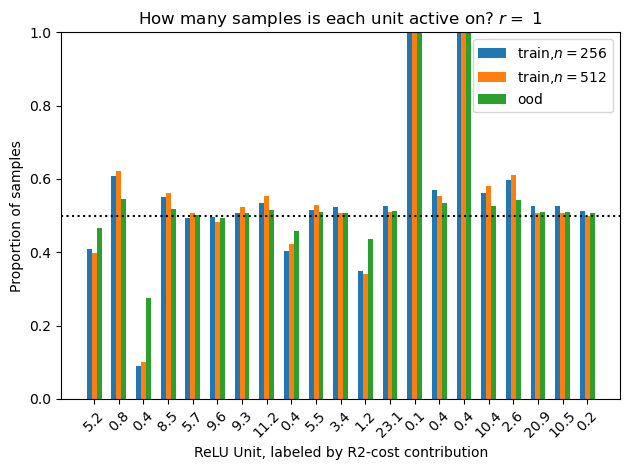

In [ ]:
for r in rs:
    print("r =",r)
    U = np.load(path+job_name+f"_labelnoise0/r{r}U.npy")
    Sigma = np.load(path+job_name+f"_labelnoise0/r{r}Sigma.npy")
    V = np.load(path+job_name+f"_labelnoise0/r{r}V.npy")
    A = np.load(path+job_name+f"_labelnoise0/r{r}A.npy")
    B = np.load(path+job_name+f"_labelnoise0/r{r}B.npy")
    W = (U*Sigma)@V.T
    rowwise1norms = np.linalg.norm(W,axis=1,ord=1)
    ratios = np.abs(B) / np.linalg.norm(W,axis=1,ord=1)
    rowwise2norms = np.linalg.norm(W,axis=1,ord=2)
    units = pd.DataFrame({"R2-cost contribution":np.abs(A)*rowwise2norms,"|b| / ||w||_1":ratios})
    # units["[-1/2,1/2]"] = ratios <= 1/2
    # units["[-1,1] but not [-1/2,1/2]"] = (1/2 < ratios) * (ratios <= 1)
    # units["not [-1,1]"] = ratios > 1

    datasetsize = 2048
    trainX = gen_data(datasetsize=datasetsize,r=r,seed=1,std=0,labelnoiseseed=0)[0]
    for n in res.n.unique():
        units[f"# training active,n={n}"] = ((W@trainX[:n].cpu().numpy().T).T + B > 0).sum(axis=0)
        units[f"% training active,n={n}"] = units[f"# training active,n={n}"] / n
    units["# validation active"] = ((W@validationX.cpu().numpy().T).T + B > 0).sum(axis=0)
    units["% validation active"] = units["# validation active"] / datasetsize
    units["# generalization active"] = ((W@generalizationX.cpu().numpy().T).T + B > 0).sum(axis=0)
    units["% generalization active"] = units["# generalization active"] / datasetsize
    units["# ood active"] = ((W@oodX.cpu().numpy().T).T + B > 0).sum(axis=0)
    units["% ood active"] = units["# ood active"] / datasetsize

    print("\nTOTALS:\n~~~~~~~\n",units.sum())
    print("\nunit-wise table:\n~~~~~~~\n")
    display(units)
    shift = -0.2
    width = 0.2
    for n in res.n.unique():
        if n >= np.max(res.n.unique())/2:
            plt.bar(units.index+shift,units[f"% training active,n={n}"],label=f"train,$n={n}$",width=width,tick_label=units["R2-cost contribution"].round(1))
            shift += width
    # plt.bar(units.index,units["% generalization active"],label="gen",width=width)
    plt.bar(units.index+shift,units["% ood active"],label="ood",width=width)
    plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.title(f"How many samples is each unit active on? $r =$ {r}")
    plt.xlabel("ReLU Unit, labeled by R2-cost contribution")
    plt.ylabel("Proportion of samples")
    plt.axhline(0.5,linestyle=":",color="k")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"samples_active_by_unit_r{r}")
    plt.show()


# Active Subspace

## evaluate gradients and compute singular values and active subspaces

In [ ]:
grads = []
sv = []
active_subspace = []
subspace_dist = []

for rownum, row in res.iterrows():
    #compute ground truth active subspace
    funcseed = 42
    d = 20
    k = d+1
    ln = row['sigma']
    if int(ln) == ln:
        ln = int(ln)
    U = np.load(path+job_name+f"_labelnoise{ln}/r{row['r']}U.npy")
    Sigma = np.load(path+job_name+f"_labelnoise{ln}/r{row['r']}Sigma.npy")
    V = np.load(path+job_name+f"_labelnoise{ln}/r{row['r']}V.npy")
    W = np.load(path+job_name+f"_labelnoise{ln}/r{row['r']}W.npy")
    A = np.load(path+job_name+f"_labelnoise{ln}/r{row['r']}A.npy")
    B = np.load(path+job_name+f"_labelnoise{ln}/r{row['r']}B.npy")

    #evaluate gradients
    generalizationX.requires_grad = True
    predY = row["Model"](generalizationX)
    grad = torch.autograd.grad(predY, generalizationX,
                            grad_outputs=torch.ones_like(predY),
                            create_graph=True)[0].detach().cpu().numpy()
    grads.append(grad)
    #compute active subspace and singular values
    Uhat,Shat,VhatT = np.linalg.svd(grad)
    Vhat = VhatT.T[:,:row["r"]] #form the basis for the active subspace
    active_subspace.append(Vhat)
    sv.append(Shat)

    subspace_dist.append(np.linalg.norm(V@V.T - Vhat@Vhat.T,2))

res["Gradient Evaluations"] = grads
res["Gradient Singular Values"] = sv
res["Active Subspace"] = active_subspace
res["Active Subspace Distance"] = subspace_dist
res["Principal Angle (Degrees)"] = np.degrees(np.arcsin(res["Active Subspace Distance"]))

res

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,...,Out-of-Distribution Generalization,Out-of-Distribution Generalization$/\sigma^2$,Out-of-Distribution Squared Errors,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015077,...,0.738775,NaN,"[0.060305182, 0.0012113921, 0.021405736, 0.023...",0.067967,3.075086,"[[-0.010460283, 0.09994252, -6.319024, -1.8302...","[968.3079, 11.140296, 3.0136247, 1.777519, 1.2...","[[0.0061626825], [-0.011433517], [0.59685826],...",0.007625,0.436897
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.188534,...,1.495375,23.925995,"[2.0072236, 0.7148368, 0.42598298, 0.041817505...",0.081244,3.675767,"[[0.12441416, 0.10840487, -6.1558084, -1.78000...","[946.4618, 21.573143, 14.949121, 12.548966, 10...","[[-0.0046804603], [-0.017624864], [0.5954447],...",0.046765,2.680417
2,1,0.00,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8729, 1340.8097, 1340.7502, 1340.6937, 1...","[Linear(in_features=20, out_features=1000, bia...",0.028895,...,0.928619,NaN,"[0.5423617, 0.00019514473, 0.10284095, 0.03414...",0.068483,3.098423,"[[-0.018078368, 0.014159506, -6.263246, -1.764...","[960.09735, 11.421275, 9.020982, 3.8924668, 3....","[[0.0042218138], [-0.01283936], [0.59729654], ...",0.014436,0.827163
3,1,0.25,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19432, 60.090363, 59.986618, 59.883083, 59...","[1340.8741, 1340.8131, 1340.7559, 1340.7021, 1...","[Linear(in_features=20, out_features=1000, bia...",0.261582,...,2.024628,32.394054,"[3.135934, 0.3618852, 0.875066, 0.40276155, 0....",0.089610,4.054315,"[[0.1282249, -0.026078656, -6.1416636, -1.7689...","[937.7468, 22.802223, 18.968557, 16.833582, 8....","[[-0.007114538], [-0.018984852], [0.5939684], ...",0.060169,3.449539
4,1,0.00,64,2,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8796, 1340.8251, 1340.7732, 1340.7236, 1...","[Linear(in_features=20, out_features=1000, bia...",0.474495,...,3.591669,NaN,"[6.962227, 0.22345194, 3.1312342, 0.329659, 0....",0.156597,7.085030,"[[-0.08034401, 0.10776679, -6.7674446, -1.7636...","[902.139, 33.153008, 25.374361, 17.12861, 11.0...","[[0.0049966406], [0.03832021], [-0.59356856], ...",0.081413,4.669806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,0.25,512,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.214455, 29.384083, 23.153172, 9.058229, 3....","[29117.865, 29085.053, 29010.55, 28983.273, 29...","[Linear(in_features=20, out_features=1000, bia...",0.152909,...,0.840020,13.440313,"[2.9640167, 0.56180215, 0.7039926, 0.14192781,...",0.042721,1.932842,"[[0.26911893, -0.12684332, -5.916502, -1.47525...","[974.94916, 22.900154, 22.40455, 20.162556, 19...","[[-0.0022456655], [0.0074224113], [-0.59546536...",0.014623,0.837866
188,1,0.00,512,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[41.916046, 29.09217, 22.929085, 9.113097, 3.2...","[29282.191, 29282.56, 29232.979, 29230.559, 29...","[Linear(in_features=20, out_features=1000, bia...",0.020823,...,0.075527,NaN,"[0.00023539882, 0.10490641, 0.046391707, 0.083...",0.004895,0.221454,"[[-0.018090181, 0.13530715, -6.295621, -1.7022...","[963.0614, 10.41965, 10.041414, 8.637542, 7.41...","[[0.007876986], [-0.01061464], [0.5984111], [0...",0.001527,0.087502
189,1,0.25,512,9,

# Tuning Hyperparameters

##  determine the lambda parameter that gets the best Validation MSE for each (r,n,L)

In [24]:
validationmse_vs_lambda = res.pivot_table(values="Validation MSE",index = ("r","sigma","n","L","Activations"),columns=["lambda"])
validationmse_vs_lambda

lambda                      0.00001   0.00010   0.00100
r sigma n   L Activations                              
1 0.00  64  2 relu         0.459887  0.030106  0.016125
            3 relu         3.560966  1.450470  0.854000
            4 relu         3.635967  2.373056  1.230832
            5 relu         3.067323  2.898385  1.735847
            6 relu         3.009743  2.919143  2.072714
...                             ...       ...       ...
  0.25  512 5 relu         0.192688  0.144867  0.131820
            6 relu         0.200670  0.153100  0.141477
            7 relu         0.205761  0.165091  0.155812
            8 relu         0.208954  0.167275  0.158350
            9 relu         0.209748  0.173014  0.158629

[64 rows x 3 columns]

In [25]:
bestlambda = validationmse_vs_lambda.idxmin(axis=1)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(bestlambda)

r  sigma  n    L  Activations
1  0.00   64   2  relu           0.0010
               3  relu           0.0010
               4  relu           0.0010
               5  relu           0.0010
               6  relu           0.0010
               7  relu           0.0010
               8  relu           0.0010
               9  relu           0.0010
          128  2  relu           0.0010
               3  relu           0.0010
               4  relu           0.0010
               5  relu           0.0010
               6  relu           0.0001
               7  relu           0.0001
               8  relu           0.0001
               9  relu           0.0001
          256  2  relu           0.0010
               3  relu           0.0001
               4  relu           0.0010
               5  relu           0.0010
               6  relu           0.0010
               7  relu           0.0010
               8  relu           0.0010
               9  relu           0.0010
          

In [26]:
mask = [row["lambda"] == bestlambda[row["r"]][row["sigma"]][row["n"]][row["L"]][row["Activations"]] for rowindex,row in res.iterrows()]
res = res[mask]
res

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,...,Out-of-Distribution Generalization,Out-of-Distribution Generalization$/\sigma^2$,Out-of-Distribution Squared Errors,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
0,1,0.00,64,2,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015077,...,0.738775,NaN,"[0.060305182, 0.0012113921, 0.021405736, 0.023...",0.067967,3.075086,"[[-0.010460283, 0.09994252, -6.319024, -1.8302...","[968.3079, 11.140296, 3.0136247, 1.777519, 1.2...","[[0.0061626825], [-0.011433517], [0.59685826],...",0.007625,0.436897
1,1,0.25,64,2,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.188534,...,1.495375,23.925995,"[2.0072236, 0.7148368, 0.42598298, 0.041817505...",0.081244,3.675767,"[[0.12441416, 0.10840487, -6.1558084, -1.78000...","[946.4618, 21.573143, 14.949121, 12.548966, 10...","[[-0.0046804603], [-0.017624864], [0.5954447],...",0.046765,2.680417
6,1,0.00,64,3,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.090473, 59.553196, 59.022366, 58.497612, 5...","[3341.178, 3340.6357, 3340.227, 3339.9487, 333...","[Linear(in_features=20, out_features=1000, bia...",0.795789,...,5.115656,NaN,"[1.0104489, 0.07830241, 0.5514143, 13.371166, ...",0.252644,11.430586,"[[-0.7581718, -0.4238171, -5.1476116, -1.47275...","[902.67303, 79.87848, 28.04255, 26.870703, 19....","[[0.0051373253], [-0.019390412], [0.602143], [...",0.068209,3.911107
7,1,0.25,64,3,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.01524, 59.480907, 58.952995, 58.43115, 57....","[3341.1697, 3340.6235, 3340.2175, 3339.9417, 3...","[Linear(in_features=20, out_features=1000, bia...",1.004314,...,5.720018,91.520294,"[3.1349883, 0.45143875, 1.233372, 15.450279, 0...",0.256396,11.600341,"[[-0.6384169, -0.3430994, -4.818685, -1.658911...","[893.2937, 80.36163, 37.60496, 27.533653, 20.8...","[[0.0061157867], [0.021653714], [-0.5979719], ...",0.091528,5.251537
12,1,0.00,64,4,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[59.943863, 59.317406, 58.692017, 58.052444, 5...","[6009.1807, 6008.5693, 6008.2847, 6008.306, 60...","[Linear(in_features=20, out_features=1000, bia...",1.146650,...,7.355909,NaN,"[7.6236773, 0.2622117, 4.492269, 14.842296, 0....",0.285388,12.912037,"[[-0.75334907, -0.27237153, -5.3068447, -1.511...","[881.2735, 80.565094, 45.1512, 30.247849, 24.2...","[[0.0095840255], [0.03340626], [-0.60059446], ...",0.104780,6.014470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1,0.25,512,7,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[43.132732, 31.679909, 25.577316, 15.505301, 2...","[17924.451, 17928.475, 17865.658, 17845.135, 1...","[Linear(in_features=20, out_features=1000, bia...",0.150527,...,1.491145,23.858328,"[2.5874426, 0.042835586, 0.08001938, 0.0342900...",0.107045,4.843101,"[[0.3639709, -0.26595986, -5.5966554, -1.26249...","[972.6678, 23.794582, 20.410435, 20.171421, 18...","[[-0.0011010686], [0.009348417], [-0.5979567],...",0.014680,0.841105
180,1,0.00,512,8,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.326103, 32.84629, 25.19228, 12.56245, 1.85...","[23213.574, 23205.74, 23121.717, 23107.248, 23...","[Linear(in_features=20, out_features=1000, bia...",0.001376,...,0.076211,NaN,"[0.009703615, 0.051656697, 0.0010900698, 0.000...",0.007158,0.323873,"[[-0.07433107, 0.12069504, -6.4712505, -1.7492...","[977.71277, 3.8769789, 3.1553507, 2.9835536, 2...","[[0.007703216], [-0.010552008], [0.5980834], [...",0.000764,0.043747
181,1,0.25,512,8,0.001,"[1e

##  determine the L parameter that gets the best validation MSE for each (r,n)

In [27]:
validationmse_vs_L = res.pivot_table(values="Validation MSE",index = ("r","sigma","n","Activations"),columns=["L"])
validationmse_vs_L = validationmse_vs_L.iloc[:,1:]
bestL = validationmse_vs_L.idxmin(axis=1)
pd.concat((validationmse_vs_L,bestL),axis=1)

3         4         5         6         7  \
r sigma n   Activations                                                     
1 0.00  64  relu         0.854000  1.230832  1.735847  2.072714  1.951556   
        128 relu         0.039944  0.055320  0.312463  0.635337  0.677985   
        256 relu         0.013103  0.013675  0.015878  0.006472  0.004389   
        512 relu         0.011100  0.004035  0.007318  0.006282  0.004520   
  0.25  64  relu         1.099366  1.530103  2.127421  2.428052  2.265282   
        128 relu         0.259919  0.304765  0.584615  0.705041  0.755506   
        256 relu         0.140188  0.139640  0.153382  0.201523  0.197561   
        512 relu         0.123102  0.131915  0.131820  0.141477  0.155812   

                                8         9  0  
r sigma n   Activations                         
1 0.00  64  relu         1.882343  1.965295  3  
        128 relu         0.703377  0.734786  3  
        256 relu         0.006689  0.009719  7  
        512 relu         0.001600  0.002022  8  
  0.25  64  relu         2.174552  2.227220  3  
        128 relu         0.768017  0.793357  3  
        256 relu         0.205560  0.206150  4  
        512 relu         0.158350  0.158629  3

In [28]:
mask = [row["L"] == bestL[row["r"]][row["sigma"]][row["n"]][row["Activations"]] for rowindex,row in res.iterrows()]
bestLres = res[mask]
bestLres

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,...,Out-of-Distribution Generalization,Out-of-Distribution Generalization$/\sigma^2$,Out-of-Distribution Squared Errors,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
6,1,0.00,64,3,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.090473, 59.553196, 59.022366, 58.497612, 5...","[3341.178, 3340.6357, 3340.227, 3339.9487, 333...","[Linear(in_features=20, out_features=1000, bia...",0.795789,...,5.115656,NaN,"[1.0104489, 0.07830241, 0.5514143, 13.371166, ...",0.252644,11.430586,"[[-0.7581718, -0.4238171, -5.1476116, -1.47275...","[902.67303, 79.87848, 28.04255, 26.870703, 19....","[[0.0051373253], [-0.019390412], [0.602143], [...",0.068209,3.911107
7,1,0.25,64,3,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.01524, 59.480907, 58.952995, 58.43115, 57....","[3341.1697, 3340.6235, 3340.2175, 3339.9417, 3...","[Linear(in_features=20, out_features=1000, bia...",1.004314,...,5.720018,91.520294,"[3.1349883, 0.45143875, 1.233372, 15.450279, 0...",0.256396,11.600341,"[[-0.6384169, -0.3430994, -4.818685, -1.658911...","[893.2937, 80.36163, 37.60496, 27.533653, 20.8...","[[0.0061157867], [0.021653714], [-0.5979719], ...",0.091528,5.251537
54,1,0.00,128,3,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.122738, 48.30033, 47.49201, 46.693417, 45....","[3340.5862, 3340.0132, 3339.9084, 3340.2136, 3...","[Linear(in_features=20, out_features=1000, bia...",0.033444,...,2.259924,NaN,"[0.0010267831, 0.0019275042, 0.0038404872, 0.0...",0.212952,9.634752,"[[-0.10933058, 0.07805874, -6.353653, -1.81220...","[966.58704, 8.432263, 5.6795645, 4.7182055, 4....","[[0.00652496], [-0.010606183], [0.5979659], [0...",0.006094,0.349135
55,1,0.25,128,3,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.07151, 48.2551, 47.452805, 46.6602, 45.867...","[3340.5728, 3339.9905, 3339.8728, 3340.1582, 3...","[Linear(in_features=20, out_features=1000, bia...",0.256418,...,2.813977,45.023636,"[1.4612789, 0.36358935, 0.11572335, 1.3083167,...",0.206118,9.325581,"[[0.1457633, 0.05503109, -5.5052576, -1.556969...","[948.60864, 39.608593, 22.398867, 14.837675, 1...","[[-0.0018576783], [0.01103179], [-0.5922884], ...",0.037123,2.127459
109,1,0.25,256,4,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.372467, 40.50025, 38.136917, 35.275146, 32...","[6007.0303, 6008.251, 6012.6133, 6020.047, 602...","[Linear(in_features=20, out_features=1000, bia...",0.136356,...,1.551104,24.817669,"[0.31173724, 0.008061663, 0.07391208, 0.193141...",0.133958,6.060783,"[[0.18212046, 0.057378244, -6.339649, -1.84619...","[963.3277, 20.453447, 20.043633, 17.288208, 13...","[[-0.0053158314], [0.008778154], [-0.60251635]...",0.022862,1.310026
126,1,0.00,256,7,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.94261, 40.098976, 32.93026, 29.654741, 26....","[17950.213, 17918.65, 17913.627, 17918.766, 17...","[Linear(in_features=20, out_features=1000, bia...",0.004073,...,0.073251,NaN,"[0.037194844, 0.0045939367, 0.00023010292, 0.0...",0.005540,0.250662,"[[-0.070086636, 0.119808435, -6.4395847, -1.73...","[972.7279, 5.587886, 4.835333, 4.206419, 3.495...","[[0.0070546777], [-0.0103090145], [0.59734315]...",0.003095,0.177322
151,1,0.25,512,3,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[44.47055, 41.716404, 38.962692, 36.397175, 33...","[3340.2095, 3344.7334, 3353.096, 3363.3096, 33...","[Linear(in_features=20, out_features=1000, bia...",0.123839,...,1.498262,23.972195,"[0.7491884, 0.0153800985, 0.008926928, 0.05571...",0.133644,6.046548,"[[0.20449838, 0.021933377, -6.8619013, -1.6987...","[967.69977, 20.869267, 16.386236, 16.2404, 14....","[[-0.0038912597], [0.006861011], [-0.59990466]...",0.012028,0.689184
180,1,0.00,512,8,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.326103, 32.84629, 25.192

In [29]:
bestLres.sort_values(by=['r','n',"sigma"])

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,...,Out-of-Distribution Generalization,Out-of-Distribution Generalization$/\sigma^2$,Out-of-Distribution Squared Errors,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
6,1,0.00,64,3,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.090473, 59.553196, 59.022366, 58.497612, 5...","[3341.178, 3340.6357, 3340.227, 3339.9487, 333...","[Linear(in_features=20, out_features=1000, bia...",0.795789,...,5.115656,NaN,"[1.0104489, 0.07830241, 0.5514143, 13.371166, ...",0.252644,11.430586,"[[-0.7581718, -0.4238171, -5.1476116, -1.47275...","[902.67303, 79.87848, 28.04255, 26.870703, 19....","[[0.0051373253], [-0.019390412], [0.602143], [...",0.068209,3.911107
7,1,0.25,64,3,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.01524, 59.480907, 58.952995, 58.43115, 57....","[3341.1697, 3340.6235, 3340.2175, 3339.9417, 3...","[Linear(in_features=20, out_features=1000, bia...",1.004314,...,5.720018,91.520294,"[3.1349883, 0.45143875, 1.233372, 15.450279, 0...",0.256396,11.600341,"[[-0.6384169, -0.3430994, -4.818685, -1.658911...","[893.2937, 80.36163, 37.60496, 27.533653, 20.8...","[[0.0061157867], [0.021653714], [-0.5979719], ...",0.091528,5.251537
54,1,0.00,128,3,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.122738, 48.30033, 47.49201, 46.693417, 45....","[3340.5862, 3340.0132, 3339.9084, 3340.2136, 3...","[Linear(in_features=20, out_features=1000, bia...",0.033444,...,2.259924,NaN,"[0.0010267831, 0.0019275042, 0.0038404872, 0.0...",0.212952,9.634752,"[[-0.10933058, 0.07805874, -6.353653, -1.81220...","[966.58704, 8.432263, 5.6795645, 4.7182055, 4....","[[0.00652496], [-0.010606183], [0.5979659], [0...",0.006094,0.349135
55,1,0.25,128,3,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.07151, 48.2551, 47.452805, 46.6602, 45.867...","[3340.5728, 3339.9905, 3339.8728, 3340.1582, 3...","[Linear(in_features=20, out_features=1000, bia...",0.256418,...,2.813977,45.023636,"[1.4612789, 0.36358935, 0.11572335, 1.3083167,...",0.206118,9.325581,"[[0.1457633, 0.05503109, -5.5052576, -1.556969...","[948.60864, 39.608593, 22.398867, 14.837675, 1...","[[-0.0018576783], [0.01103179], [-0.5922884], ...",0.037123,2.127459
126,1,0.00,256,7,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.94261, 40.098976, 32.93026, 29.654741, 26....","[17950.213, 17918.65, 17913.627, 17918.766, 17...","[Linear(in_features=20, out_features=1000, bia...",0.004073,...,0.073251,NaN,"[0.037194844, 0.0045939367, 0.00023010292, 0.0...",0.005540,0.250662,"[[-0.070086636, 0.119808435, -6.4395847, -1.73...","[972.7279, 5.587886, 4.835333, 4.206419, 3.495...","[[0.0070546777], [-0.0103090145], [0.59734315]...",0.003095,0.177322
109,1,0.25,256,4,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.372467, 40.50025, 38.136917, 35.275146, 32...","[6007.0303, 6008.251, 6012.6133, 6020.047, 602...","[Linear(in_features=20, out_features=1000, bia...",0.136356,...,1.551104,24.817669,"[0.31173724, 0.008061663, 0.07391208, 0.193141...",0.133958,6.060783,"[[0.18212046, 0.057378244, -6.339649, -1.84619...","[963.3277, 20.453447, 20.043633, 17.288208, 13...","[[-0.0053158314], [0.008778154], [-0.60251635]...",0.022862,1.310026
180,1,0.00,512,8,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[42.326103, 32.84629, 25.19228, 12.56245, 1.85...","[23213.574, 23205.74, 23121.717, 23107.248, 23...","[Linear(in_features=20, out_features=1000, bia...",0.001376,...,0.076211,NaN,"[0.009703615, 0.051656697, 0.0010900698, 0.000...",0.007158,0.323873,"[[-0.07433107, 0.12069504, -6.4712505, -1.7492...","[977.71277, 3.8769789, 3.1553507, 2.9835536, 2...","[[0.007703216], [-0.010552008], [0.5980834], [...",0.000764,0.043747
151,1,0.25,512,3,0.001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[44.47055, 41.716404, 38.962692, 3

## What are the chosen lambda and L for each model?

In [30]:
bestres = pd.concat((res[res["L"] == 2],bestLres))

In [31]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(bestres.loc[:,:"lambda"].pivot_table(index=["r","sigma","n","L"],values=["lambda"]))

lambda
r sigma n   L        
1 0.00  64  2  0.0010
            3  0.0010
        128 2  0.0010
            3  0.0010
        256 2  0.0010
            7  0.0010
        512 2  0.0001
            8  0.0010
  0.25  64  2  0.0010
            3  0.0010
        128 2  0.0010
            3  0.0010
        256 2  0.0010
            4  0.0010
        512 2  0.0010
            3  0.0010

# Plotting

In [32]:
fontname = "Times New Roman"
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## plots of all the singular values

/tmp/ipykernel_1027753/336815347.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,len(res.n.unique()),1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 0
1,64,2 [2.1396784e+01 2.4616809e-01 6.6592328e-02 3.9277993e-02 2.7993761e-02
 1.5359454e-02 1.0541299e-02 7.7754818e-03 4.4583580e-03 3.6436715e-03
 2.5036421e-03 8.0938759e-04 3.1657331e-04 1.3219180e-04 5.3294192e-05
 2.6455053e-05 1.5462194e-05 8.2320075e-06 4.2194702e-06 2.9719076e-06] 0 0
0 0
1,64,3 [1.9946445e+01 1.7650818e+00 6.1965865e-01 5.9376425e-01 4.2077398e-01
 3.2596138e-01 2.5908962e-01 2.0014995e-01 1.7099734e-01 1.0033583e-01
 7.4638285e-02 5.8360759e-02 5.6540120e-02 3.7001558e-02 3.0777404e-02
 2.8894015e-02 2.2351939e-02 1.3414010e-02 1.1635773e-02 9.1501065e-03] 0 0
0 0
1,64,4 [1.9473577e+01 1.7802539e+00 9.9770999e-01 6.6838932e-01 5.3580242e-01
 4.3935469e-01 3.3786532e-01 2.8775486e-01 2.1435854e-01 1.4867415e-01
 1.1345210e-01 9.6210875e-02 8.5635804e-02 5.9537336e-02 5.0126422e-02
 2.9948877e-02 2.7441004e-02 2.1891827e-02 1.7739704e-02 1.5523871e-02] 0 0
0 0
1,64,5 [20.09737     2.0238853   1.2882226   0.89726627  0.79588455  0.55788016
  0.48853162  0.

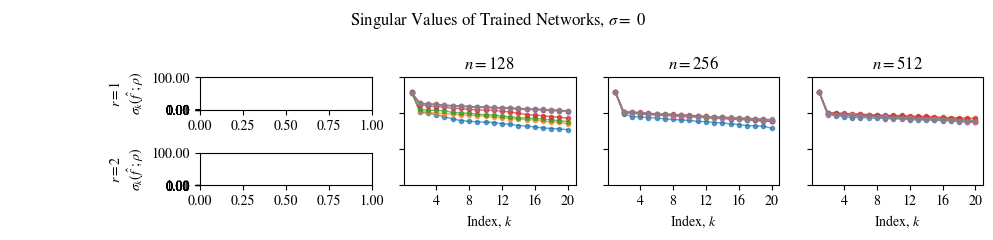

/tmp/ipykernel_1027753/336815347.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,len(res.n.unique()),1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 0
1,64,2 [2.0914049e+01 4.7670361e-01 3.3033204e-01 2.7729562e-01 2.3218228e-01
 1.0265276e-01 6.7079164e-02 4.6159714e-02 3.9333440e-02 2.7263671e-02
 1.9040022e-02 1.4628446e-02 1.3389860e-02 8.5496139e-03 7.8688888e-03
 5.1928083e-03 2.2881341e-03 2.1954949e-03 1.6409756e-03 1.0757650e-03] 0 0
0 0
1,64,3 [1.9739189e+01 1.7757580e+00 8.3096009e-01 6.0841352e-01 4.6030870e-01
 3.6481103e-01 2.8414354e-01 2.1117407e-01 1.6441423e-01 1.2804912e-01
 9.9232383e-02 8.3614357e-02 4.8512708e-02 4.4222735e-02 2.9752631e-02
 2.6211305e-02 1.8980375e-02 1.8319180e-02 1.2796283e-02 7.4518961e-03] 0 0
0 0
1,64,4 [1.9469404e+01 1.8387692e+00 9.7756034e-01 7.2023124e-01 6.0555393e-01
 3.9722019e-01 3.3494145e-01 2.7432916e-01 2.3515546e-01 1.5431225e-01
 1.3137627e-01 1.2350110e-01 1.2071130e-01 6.2946290e-02 4.7041252e-02
 4.0172890e-02 2.5937837e-02 2.1636587e-02 1.9299503e-02 1.5090061e-02] 0 0
0 0
1,64,5 [20.080812    2.086509    1.2516007   0.9531742   0.9216674   0.5064405
  0.44812483  0.4

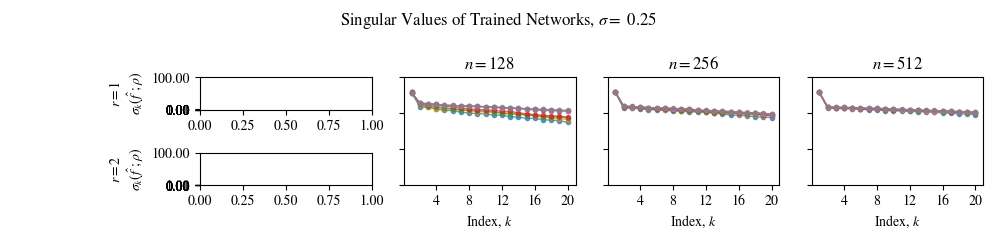

In [33]:
#all the singular values
for std in labelnoise:
    f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(10,2.4))
    ax = ax[np.newaxis]
    for rownum,row in res.iterrows():
        if row['sigma'] == std:
            whichrow = np.where(row['r'] == res.r.unique())[0][0]
            whichcol = np.where(row['n'] == res.n.unique())[0][0]
            print(whichrow,whichcol)
            print(rf"{row['r']},{row['n']},{row['L']}",row["Gradient Singular Values"]/np.sqrt(2048),whichrow,whichcol)
            ax[whichrow,whichcol].semilogy(row["Gradient Singular Values"]/np.sqrt(2048),label=rf"$L={row['L']}$",linewidth=1,alpha=0.7,marker=".")
            ax[whichrow,whichcol].set_xticks(list(range(3,20,4)),list(range(4,21,4)))
            ax[whichrow,whichcol].set_ylim(10**-9,10**3)
            ax[0,whichcol].set_title(rf"$n={row['n']}$")
            ax[-1,whichcol].set_xlabel(rf"Index, $k$")
    plt.subplot(2,len(res.n.unique()),1)
    leg = plt.legend()
    leg = plt.legend(bbox_to_anchor=(-1, 1))
    leg.get_frame().set_edgecolor('b')
    leg.get_frame().set_linewidth(0.0)
    plt.subplot(2,len(res.n.unique()),1)
    plt.ylabel(r"$r=1$"+"\n"+r"$\sigma_k(\hat f;\rho)$")
    plt.yticks([10**p for p in range(-12,3,2)])
    plt.subplot(2,len(res.n.unique()),len(res.n.unique())+1)
    plt.ylabel(r"$r=2$"+"\n"+r"$\sigma_k(\hat f;\rho)$")
    plt.yticks([10**p for p in range(-12,3,2)])
    plt.suptitle(rf"Singular Values of Trained Networks, $\sigma =$ {std}")
    plt.tight_layout()
    plt.savefig(job_name+f"_labelnoise{std}/sv.pdf",dpi=300)#,bbox_extra_artists=(leg,), bbox_inches='tight')
    plt.show()

## Plots of L vs Validation error

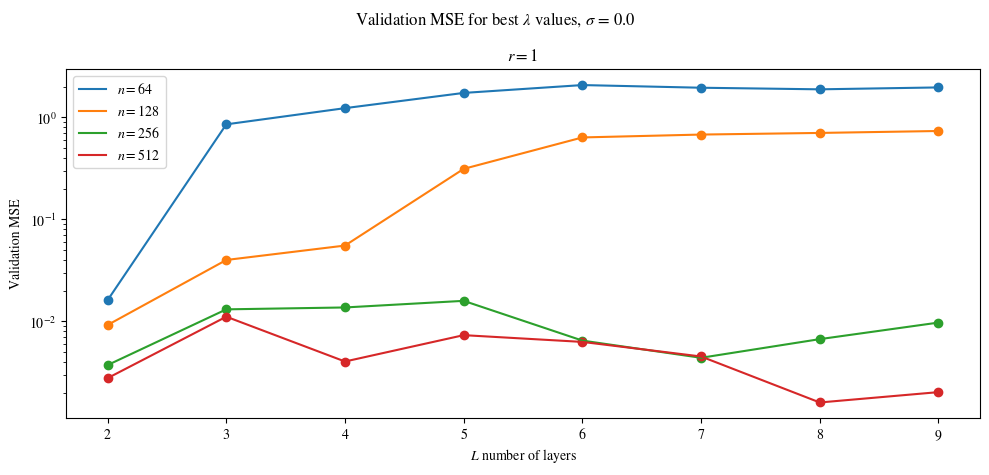

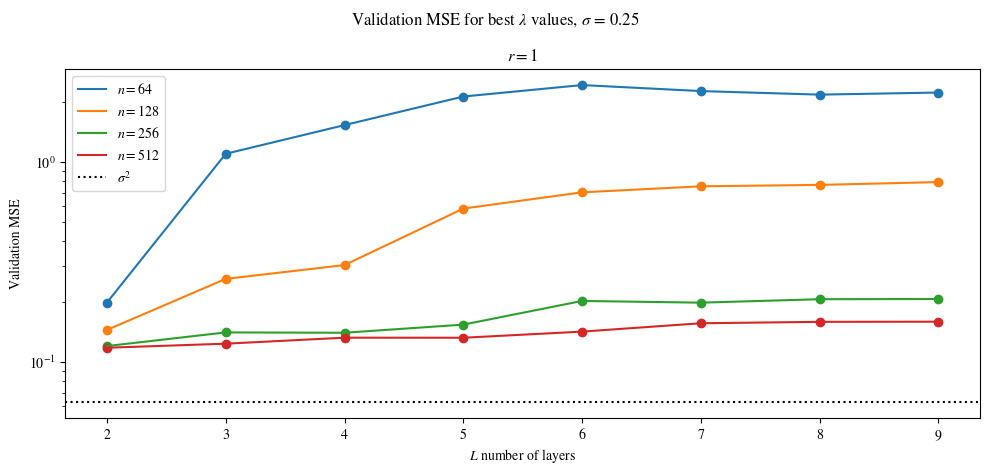

In [34]:
for std in res["sigma"].unique():
    f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=1, sharex=True, sharey=False, figsize=(10,4.8))
    ax = [ax]
    for rnum,r in enumerate(res.r.unique()):
        for n in res.n.unique():
                res_rnstd = res[(res.r == r) * (res.n == n) * (res["sigma"] == std)]
                ax[rnum].scatter(res_rnstd.L,res_rnstd[["Validation MSE"]])
                ax[rnum].semilogy(res_rnstd.L,res_rnstd[["Validation MSE"]],label=rf"$n={n}$")
                for _,model in res_rnstd.iterrows():
                    text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}'
                    # ax[rnum].annotate(text,[model.L,model[["Validation MSE"]]],fontsize=1)
        ax[rnum].set_xlabel("$L$ number of layers")
        ax[rnum].set_title(rf"$r={r}$")
        if std > 0:
            ax[rnum].axhline(y=std**2, color='k', linestyle=':',label="$\sigma^2$")
        ax[0].set_ylabel("Validation MSE")
        f.suptitle(rf"Validation MSE for best $\lambda$ values, $\sigma$ = {std}")
    ax[0].legend()
    f.tight_layout()
    if int(std) == std:
        std = int(std)
    f.savefig(job_name+f"_labelnoise{std}/ValidationMSE.pdf",dpi=300)
    plt.show()

## Performance metrics with/without linear layers

In [35]:
columnwidth = 6.17406722223
markersize = 4
colors = {  
    0   :"C0",
    0.25:"C1",
    # 0.5 :"C2",
    # 1   :"C3"
}
labels = {
    "without extra layers":"-",
    "with extra layers"   :"--",
    #"without linear layers":"-",
    #"with linear layers"   :"--",
}
markers = {
    "without extra layers":".",
    "with extra layers"   :"x",
    #"without linear layers":".",
    #"with linear layers"   :"x",
}

### generalization

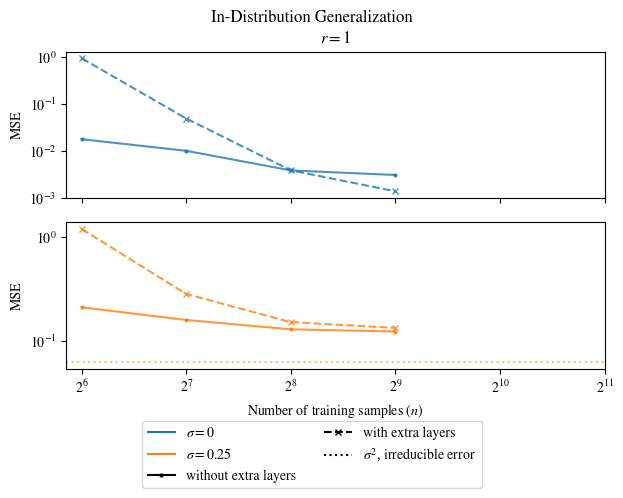

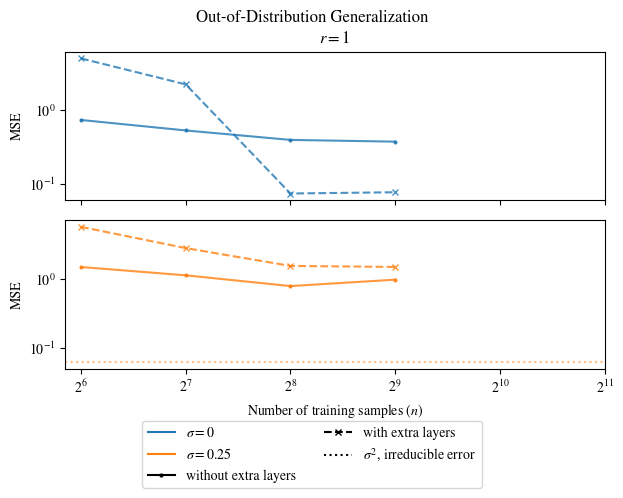

In [36]:
#generalization and OOD errors
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=ls, label=label, marker = markers[label], markersize=markersize) for label,ls in labels.items()
] 
handles += [
        Line2D([0], [0], color='k', ls=':', label='$\sigma^2$, irreducible error'),
]

for metric in ['In-Distribution Generalization','Out-of-Distribution Generalization']:
    standard_errors = metric[:-3] + 'SEM'
    f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=2, sharex=True, sharey="row", figsize=(columnwidth,4.25))
    ax = ax[:,np.newaxis]
    #just the data without label noise in the first row
    for col,r in enumerate(res.r.unique()):
        for row,sigmas in enumerate([[0],[0.25]]):#[[0],[0.25,0.5,1]]
            for sigma in sigmas:
                for label,ls in labels.items():
                    if label == "with extra layers":#"with linear layers":
                        curr = bestLres[(bestLres.r == r) * (bestLres["sigma"] == sigma)]
                    elif label == "without extra layers":#"without linear layers":
                        curr = res[(res.L == 2) * (res.r == r) * (res["sigma"]==sigma)]
                    points = curr[[metric]].values[:,0]
                    # errorbars = curr[[standard_errors]].values[:,0]
                    marker = markers[label]
                    ax[row,col].plot(curr.n,points,
                                        linestyle=ls,
                                        marker=marker,
                                        markersize=markersize,
                                        color=colors[sigma],
                                        alpha=0.8)
                    #horizontal dashed line for minimal possible MSE (ie sigma^2) in plots with label noise
                    ax[1,col].axhline(y=sigma**2, color=colors[sigma], linestyle=':',alpha=0.3)
                    # for (_,model),y in zip(curr.iterrows(),points):
                    #     text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nL = {model["L"]}\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}\nVal{model["Validation MSE"]:.1e}'
                    #     ax[row,col].annotate(text,[model["n"],y],fontsize=1)
            #plot set up
            ax[row,col].set_xscale("log",base=2)
            ax[row,col].set_xticks([2**k for k in range(6,12)])
            ax[row,col].set_yscale("log",base=10)
            ax[row,0].set_ylabel(f"MSE",wrap=True)
            ax[0,col].set_title(rf"$r={r}$") 
            ax[1,col].set_xlabel("Number of training samples ($n$)")
            ax[row,col].minorticks_off()
    f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.03))
    plt.suptitle(f"{metric}")
    plt.tight_layout(pad=0.5,h_pad=1.08, w_pad=1.08)
    plt.savefig(job_name+f"{metric}.pdf",dpi=300,bbox_inches='tight')
    plt.show()

### singular values

1 64 0 0
1 128 0 1
1 256 0 2
1 512 1 0


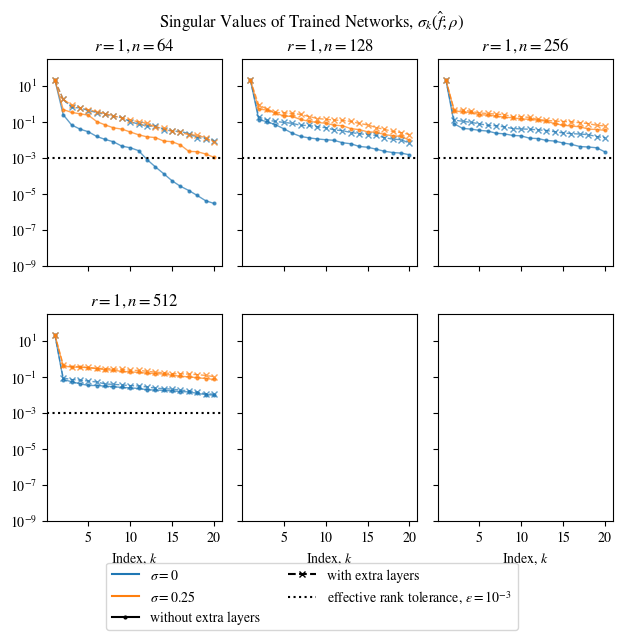

In [37]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=ls, label=label, marker = markers[label], markersize=markersize) for label,ls in labels.items()
] 
handles += [Line2D([0], [0], color='k', ls=':', label=r"effective rank tolerance, $\varepsilon = 10^{-3}$")]

ranktol = 1e-3
f, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(columnwidth,5.75))
for rnum,r in enumerate(res.r.unique()):
        rnum = 0
        for nnum,n in enumerate(res.n.unique()):
            row = 2*rnum + nnum // 3
            col = nnum % 3
            print(r,n,row,col)
            for sigma in labelnoise:
                for label,ls in labels.items():
                    if label == "with extra layers":#"with linear layers":
                        curr = bestLres[(bestLres.r == r) * (bestLres.n == n) * (bestLres["sigma"] == sigma)]
                    elif label == "without extra layers":#"without linear layers":
                        curr = res[(res.L == 2) * (res.n == n) * (res.r == r) * (res["sigma"]==sigma)]
                    marker = markers[label]
                    ax[row,col].semilogy(curr["Gradient Singular Values"].values[0]/np.sqrt(2048),
                        linestyle=ls,
                        linewidth=1,
                        alpha=0.7,
                        marker=marker,
                        markersize=markersize,
                        color=colors[sigma])
            ax[row,col].axhline(y=ranktol, color='k', linestyle=':',alpha=1, label = r"effective rank tolerance, $\varepsilon = 10^{-3}$")
            ax[row,col].set_xticks(list(range(4,20,5)),list(range(5,21,5)))
            ax[0,0].set_yticks([10**p for p in range(-9,3,2)])
            ax[row,col].set_title(rf"$r={r},n={n}$")
            ax[-1,col].set_xlabel(rf"Index, $k$")
            ax[row,col].set_ylim(10**(-9),10**(2.5))
f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.03))
plt.suptitle(r"Singular Values of Trained Networks, $\sigma_k(\hat{f};\rho)$")
plt.tight_layout(pad=0.5,h_pad=1.08, w_pad=1.08)
plt.savefig(job_name+f"_labelnoise_sv.pdf",dpi=300, bbox_inches='tight')
plt.show()
handles.pop()

### active subspaces

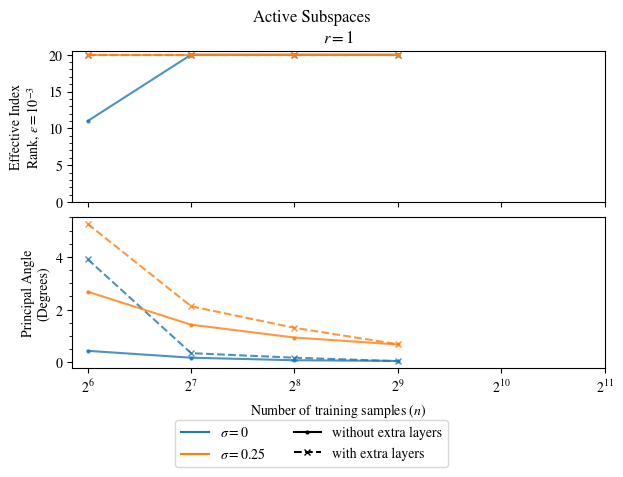

In [38]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=ls, label=label, marker = markers[label], markersize=markersize) for label,ls in labels.items()
] 

#active subspace error plot
f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=2, sharex=True, sharey=False, figsize=(columnwidth,4.25))
ax = ax[:,np.newaxis]
for row,metric in enumerate([r"Effective Index Rank, $\varepsilon = 10^{-3}$","Principal Angle (Degrees)"]):
    for col,r in enumerate(res.r.unique()):
        for sigma in [0,0.25]:#,0.5,1]:
            for label,ls in labels.items():
                if label == "with extra layers":#"with linear layers":
                    curr = bestLres[(bestLres.r == r) * (bestLres["sigma"] == sigma)]
                elif label == "without extra layers":#"without linear layers":
                    curr = res[(res.L == 2) * (res.r == r) * (res["sigma"]==sigma)]
                if metric == "Principal Angle (Degrees)":
                    points = curr[[metric]].values[:,0]
                elif metric == r"Effective Index Rank, $\varepsilon = 10^{-3}$":
                    points = (np.array(curr["Gradient Singular Values"].tolist())/np.sqrt(2048) > ranktol).sum(axis=1)
                    ax[row,col].set_yticks(np.arange(0,21,5))
                    ax[row,col].set_ylim(0,20.5)
                marker = markers[label]
                ax[row,col].plot(curr.n,points,
                                    linestyle=ls,
                                    color=colors[sigma],
                                    marker=marker,
                                    markersize=markersize,
                                    alpha=0.8)
                # for (_,model),y in zip(curr.iterrows(),points):
                #     text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nL = {model["L"]}\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}\nVal{model["Validation MSE"]:.1e}'
                #     ax[row,col].annotate(text,[model["n"],y],fontsize=1)
        #plot set up
        ax[row,0].set_ylabel(metric[:15] + '\n' + metric[16:])
        ax[0,col].set_title(rf"$r={r}$") 
        ax[0,col].set_yticks(range(21), minor=True)
        ax[row,col].set_xscale("log",base=2)
        ax[row,col].set_xticks([2**k for k in range(6,12)])
        ax[1,col].set_xlabel("Number of training samples ($n$)")
        ax[row,col].minorticks_on()
f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.03))
plt.suptitle(f"Active Subspaces")
plt.tight_layout(pad=0.5,h_pad=0.5, w_pad=0.5)
plt.savefig(job_name+f"Active Subspaces.pdf",dpi=300,bbox_inches='tight')
plt.show()

## Training v Epoch

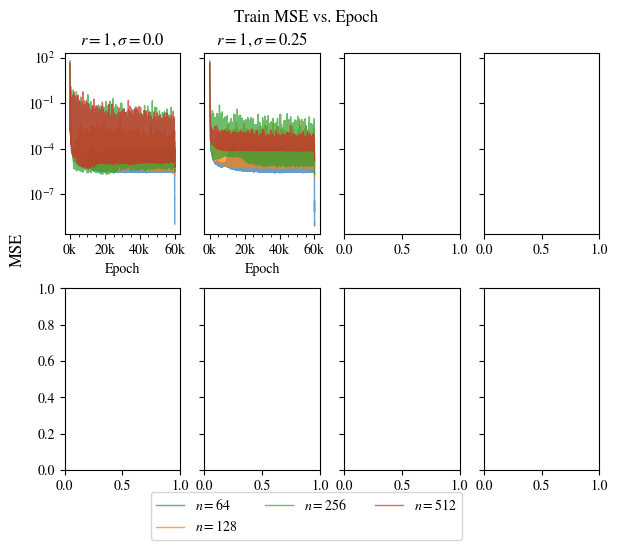

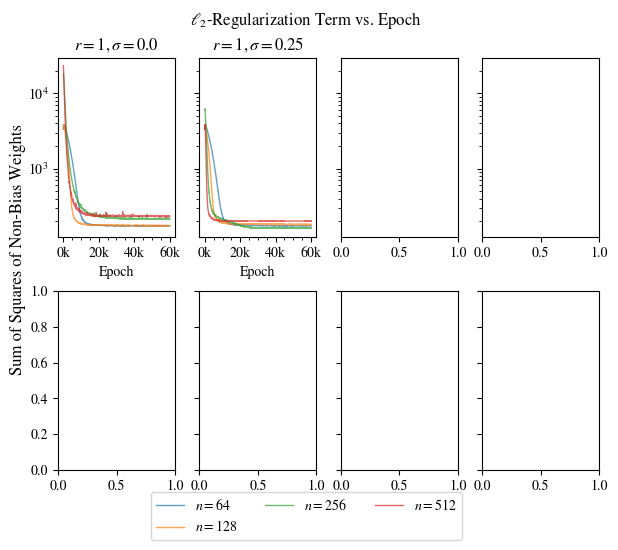

In [39]:
sigmas = np.array([0,0.25,0.5,1])
for metric in ["Train MSE","Weight Decay"]:
    f, ax = plt.subplots(nrows=2, ncols=4, sharex=False, sharey='row', figsize=(columnwidth,5))
    for rownum,row in bestLres.iterrows():
        sigma = row['sigma']
        r = row['r']
        whichcol = np.where(sigma == sigmas)[0][0]
        whichrow = 0 if r == 1 else 1
        ax[whichrow,whichcol].semilogy(row[metric],label=rf"$n = {row['n']}$",linewidth=1,alpha=0.7)
        ax[whichrow,whichcol].set_title(rf"$r = {row['r']},\sigma = {sigma}$")
        ax[whichrow,whichcol].set_xlabel("Epoch")
        ax[whichrow,whichcol].set_xticks(range(0,60100,20000),labels=[str(i)+"k" for i in range(0,61,20)])
        handles, labels = ax[whichrow,whichcol].get_legend_handles_labels()
        ax[whichrow,whichcol].minorticks_on()
    if metric == "Weight Decay":
        titlestr = rf"$\ell_2$-Regularization Term vs. Epoch"
        ystr = rf"Sum of Squares of Non-Bias Weights"
    else:
        titlestr = rf"{metric} vs. Epoch"
        ystr = "MSE"
    f.legend(handles, labels, ncol=3, loc = 'upper center', bbox_to_anchor=(0.5,0.03))
    f.suptitle(titlestr)
    f.supylabel(ystr)
    plt.tight_layout(pad=0.5,h_pad=0.5, w_pad=0.5)
    f.savefig(job_name+metric+".pdf",dpi=300,bbox_inches='tight')
    plt.show()